Import libraries

In [2]:
# math and data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
RANDOM_SEED = 2018
seed(RANDOM_SEED)


Import datasets

In [3]:
consumption_train = pd.read_csv('../input/processedinputfiles/consumption_train.csv', index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv('../input/processedinputfiles/cold_start_test.csv', index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv('../input/submission-format/submission_format.csv', index_col='pred_id', parse_dates=['timestamp'])

In [4]:
consumption_train.head()

,series_id,timestamp,consumption,hour,is_baseTemperatureHigh,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,is_large,is_medium,is_small,is_Xlarge,is_Xsmall,is_XXlarge,is_XXsmall
1,103088,2014-12-24 00:00:00,101842.233424,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
2,103088,2014-12-24 01:00:00,105878.048906,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
3,103088,2014-12-24 02:00:00,91619.105008,2,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,103088,2014-12-24 03:00:00,94473.706203,3,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
5,103088,2014-12-24 04:00:00,96976.755526,4,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0


In [5]:
cold_start_test.head()

,series_id,timestamp,consumption,hour,is_baseTemperatureHigh,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,is_large,is_medium,is_small,is_Xlarge,is_Xsmall,is_XXlarge,is_XXsmall
1,102781,2013-02-27 00:00:00,15295.740389,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
2,102781,2013-02-27 01:00:00,15163.209562,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
3,102781,2013-02-27 02:00:00,15022.264079,2,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
4,102781,2013-02-27 03:00:00,15370.420458,3,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
5,102781,2013-02-27 04:00:00,15303.103213,4,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0


In [6]:
submission_format.head()

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,0.0,daily
1,102781,2013-03-04,20.034375,0.0,daily
2,102781,2013-03-05,19.189583,0.0,daily
3,102781,2013-03-06,18.397917,0.0,daily
4,102781,2013-03-07,20.762500,0.0,daily


How many series we have, and how much training data that corresponds to.

In [7]:
def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    assert num_training_hours == train_df.shape[0]
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)
    
describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


Since all of the training series are the same length, we'll uniformly sample a subset of series. The size of our resulting reduced data will be controlled by frac_series_to_use.

In [8]:
# choose subset of series for training
frac_series_to_use = 0.01

rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = consumption_train.series_id.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)

training_series = series_ids[series_mask]

# reduce training data to series subset
consumption_train = consumption_train[consumption_train.series_id.isin(training_series)]

# describe the reduced set
describe_training_data(consumption_train)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


The submission format takes the "cold start" consumption data to generate the power consumption forecasts for various prediction windows. Each of the series_id in the test set asks for one  of three prediction windows:

hourly - predict consumption each hour for a day (24 predictions)

daily - predict consumption each day for a week (7 predictions)

weekly - predict consumption each week for two weeks (2 predictions)


In [9]:
# confirm that every series asks for only one type of prediction
assert all(1 == submission_format.groupby('series_id').prediction_window.nunique())

# use the first() prediction window value from a series_id so as not to overcount
submission_format.groupby('series_id').prediction_window.first().value_counts()

hourly    242
weekly    192
daily     191
Name: prediction_window, dtype: int64

For each series_id in the test set, the amount of hourly cold start data you are provided is never less than one day (24 consecutive consumption measurements) and can be as much as two weeks (336 consecutive consumption measurements). Cold start data only comes in full-day chunks. In other words, some series may have 3, 4, ..., 14 days worth of cold start data, but no series have 3.5, 4.1, ..., 13.9, or any other partial-day's worth of cold start data.

Since each timestep represents and hour, we can visually confirm the above claim with a simple bar plot counting the number of days in each test series.

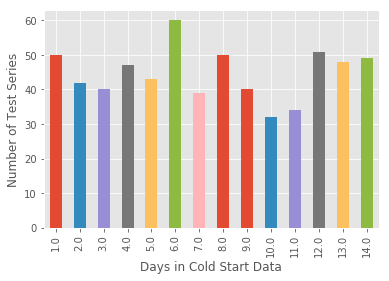

In [10]:
ax = (cold_start_test.groupby('series_id').count()
                                           .timestamp
                                           .divide(24)
                                           .value_counts()
                                           .sort_index()
                                           .plot.bar())
ax.set_xlabel('Days in Cold Start Data')
ax.set_ylabel('Number of Test Series')
plt.show()

First, for convenience, we'll add prediction_window to the test data.

We extract the series_id and prediction window from the submission format file and then merge this df wit the test data.
We then group this newly merged df by series_id and take a count of them. We also divide the count by 24 to see how many observations ask prediction window.

In [11]:
# add prediction_window to the test data
pred_windows = submission_format[['series_id', 'prediction_window']].drop_duplicates()
cold_start_test = cold_start_test.merge(pred_windows, on='series_id')

num_cold_start_days_provided = (cold_start_test.groupby('series_id')
                                               .prediction_window
                                               .value_counts()
                                               .divide(24))

num_cold_start_days_provided.head()

series_id  prediction_window
100004     weekly                4.0
100010     hourly               12.0
100012     hourly               10.0
100020     weekly               13.0
100028     daily                13.0
Name: prediction_window, dtype: float64

Now we'll plot the distribution of prediction_window for each unique length of cold start data in the test set.

In [12]:
def _count_cold_start_days(subdf):
    """ Get the number of times a certain cold-start period 
    appears in the data.
    """
    return (subdf.series_id
                 .value_counts()
                 .divide(24)  # hours to days 
                 .value_counts())

cold_start_occurrence = (cold_start_test.groupby('prediction_window')
                                        .apply(_count_cold_start_days))

cold_start_occurrence.head()

prediction_window      
daily              1.0     19
                   8.0     18
                   13.0    18
                   6.0     15
                   9.0     15
Name: series_id, dtype: int64

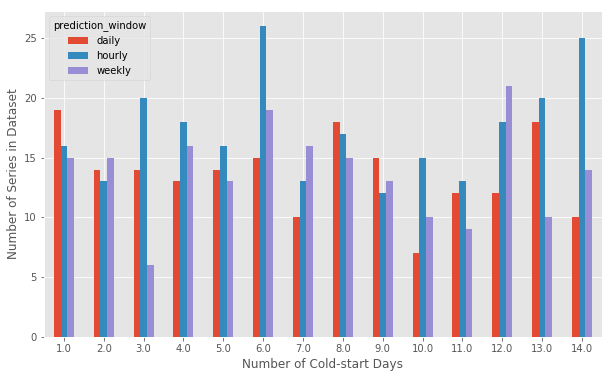

In [13]:
ax = cold_start_occurrence.unstack(0).plot.bar(figsize=(10, 6),
                                               rot=0)

ax.set_xlabel('Number of Cold-start Days')
ax.set_ylabel('Number of Series in Dataset');

The main training set, consumption_train has many series, each with 4 weeks worth of hourly data. To gain a sense of what the cold start prediction asks of you, let's look at a few examples of how the cold start data leads up to the prediction window.

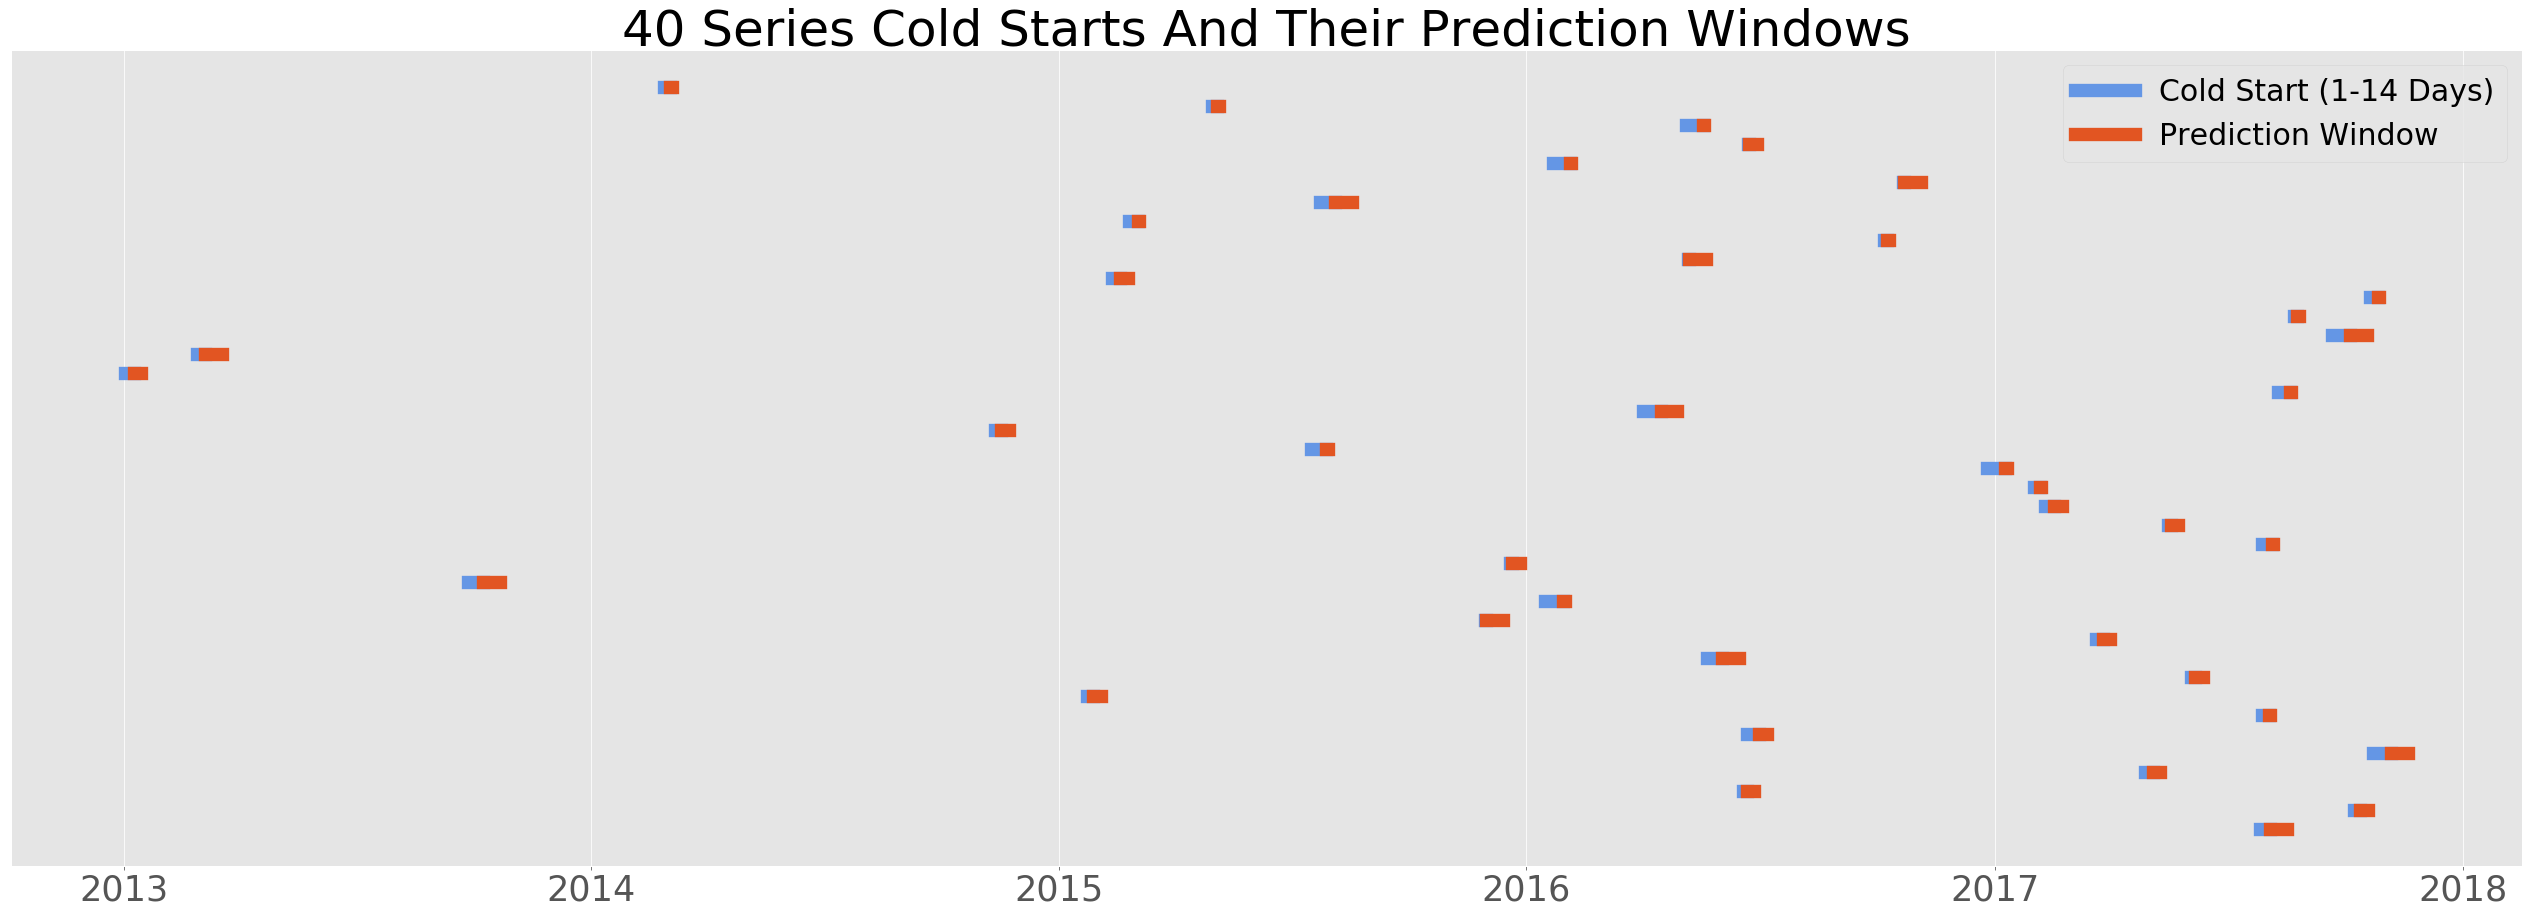

In [14]:
# visualize the cold start and prediction windows
num_to_plot = 40

fig, ax = plt.subplots(figsize=(45, 15))

cold_start_map = {'hourly': 1, 'daily': 7, 'weekly': 14}

rng = np.random.RandomState(seed=5425)
series_to_plot = rng.choice(cold_start_test.series_id.unique(), num_to_plot)

for i, series_id in enumerate(series_to_plot):
    # get relevant information about the test series from coldstart data
    series_data = cold_start_test[cold_start_test.series_id == series_id]
    start_cold = series_data.timestamp.min()
    start_preds = series_data.timestamp.max()
    
    # get prediction stop from submission format
    stop_preds = submission_format[submission_format.series_id == series_id].timestamp.max()
    
    # plot the cold start and prediction window relative sizes
    ax.plot([start_cold, start_preds], [i, i], c='#6496e5', linewidth=num_to_plot / 3)
    ax.plot([start_preds, stop_preds], [i, i], c='#e25522', linewidth=num_to_plot / 3)

# the y tick labels don't mean anything so turn them off
ax.set_yticks([])
plt.tick_params(labelsize=35)
plt.legend(['Cold Start (1-14 Days)', 
            'Prediction Window'], 
           fontsize=30)

plt.title(f'{num_to_plot} Series Cold Starts And Their Prediction Windows', fontsize=50);

Using the series consumption_train, all cold start windows from 1 to 14 days can be created, with a minimum of 14 more days that can be used to create validation sets.

Finally, let's take a look at the consumption patterns in a few series to see that they're 4 weeks.

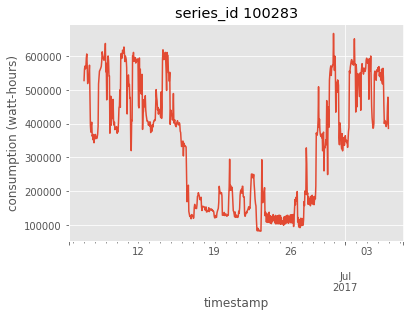

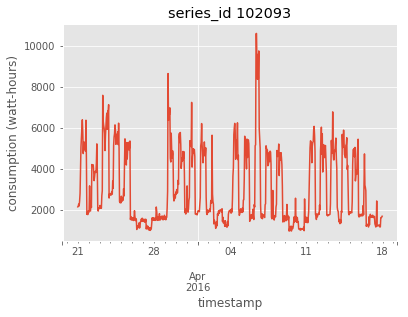

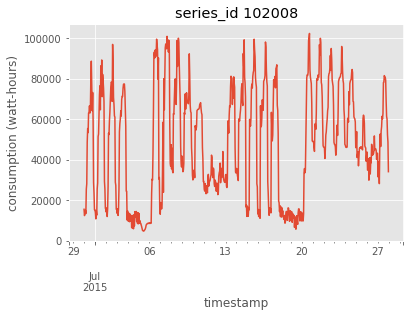

In [15]:
# plot a few consumption patterns
series_to_plot = rng.choice(consumption_train.series_id.unique(), 3)

for ser_id in series_to_plot:
    ser_data = consumption_train[consumption_train.series_id == ser_id]
    ax = ser_data.plot(x='timestamp',
                       y='consumption', 
                       title=f"series_id {int(ser_id)}",
                       legend=False)
    plt.ylabel('consumption (watt-hours)')
    plt.show()

We can see that all of the series in the training data (even though we just selected a few at the top of this notebook) have the same length.

In [16]:
(consumption_train.groupby('series_id')
                  .timestamp
                  .apply(lambda x: x.max() - x.min())
                  .value_counts())

27 days 23:00:00    10
Name: timestamp, dtype: int64

Creating Lagged variables for Timeseries. W[](http://)e'll want to convert each series into a matrix of lagged variables. The Pandas shift method on DataFrames makes this easy.

In [17]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

# example series
test_series = consumption_train[consumption_train.series_id == 100283]
create_lagged_features(test_series.consumption, lag=3).head()

,consumption,consumption_1,consumption_2,consumption_3
7396,562464.244579,570699.933083,561278.342934,527862.165731
7397,565464.153881,562464.244579,570699.933083,561278.342934
7398,593757.048480,565464.153881,562464.244579,570699.933083
7399,606651.971117,593757.048480,565464.153881,562464.244579
7400,570132.762731,606651.971117,593757.048480,565464.153881


Function to Prepare Training Data for Model

Before each series is processed, we'll need to convert it to a supervised learning problem, then scale the data. Let's create a function, prepare_training_data that we can call on each sample in our training loop.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

_X, _y, scaler = prepare_training_data(test_series.consumption, 5)
print(_X.shape)
print(_y.shape)
print(scaler)

Make Model

In [ ]:
# modeling
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# progress bar
from tqdm import tqdm

As usual with Keras, getting from imports to a simple custom model be done in just a few lines. Next we'll instantiate a Keras Sequential configuration and add to it a single recurrent cell followed by a dense layer to output regressed values. We'll also keep the number of neurons in the LSTM cell (this is just the dimensionality of the LSTM output) and the number of passes through the data small.

Note the importance of setting stateful=True below. This allows the LSTM to learn the patterns within a batch (the lagged series data). Otherwise the state would be reset after each time step, but we want the model to develop states that depend on every timestep we show it.

In [ ]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

Fit Model

Now for the fun part! Above we showed that the series in consumption_train could be used to simulate all sorts of cold start types. Here we're just going to fit each 4 week series using a 24 hour lag, so that ideally the model learns at least patterns over a single day.

To train, we pass through the consumption data, grouped by series_id. For each series, we first prepare_training_data, then fit using that data, resetting the state only after each row of the series has been seen. In this way, each lagged timeseries is learned by the network before the state is reset and the next series is passed in.

**To keep this example quick, we're only going to make a single pass through the data. An easy way to improve this benchmark is to simply change num_passes_through_data below (to a much larger number).**

In [ ]:
%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 30

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

To generate our submission, we'll loop over submission format grouping by series_id as above. Within each iteration, we'll need to

+ prepare the cold start data
+ generate the forecast

To generate the forecast, we'll

+ build up the internal state using the prepared cold start data
+ predict all hours in the prediction window
+ aggregate the forecast appropriately for the submission

To simplify the prediction loop, let's write a couple of functions to accomplish the above tasks.

Function to Generate Forecast

In [ ]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [ ]:
# copy submission format and fill in values
my_submission = submission_format.copy()

Make Predictions: Forecast the Cold Start Data

In [ ]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = cold_start_test[cold_start_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

In [ ]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

In [ ]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

In [ ]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

In [ ]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [ ]:
my_submission.head(5)

In [ ]:
#save_path = Path('..', 'data', 'submissions')
#save_path.mkdir(exist_ok=True, parents=True)

#my_submission.to_csv('../working/ouputresult/my_submmission5.csv', index_label='pred_id')

In [ ]:
import os
os.listdir('/kaggle/working') 


In [ ]:
my_submission.to_csv('../working/my_submmission5.csv', index_label='pred_id')

In [ ]:
my_submission.to_csv('my_submmission5.csv', index_label='pred_id')